# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

In [2]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


### 데이터 불러오기 (window별 데이터)

In [4]:
# 절대경로로 불러옴
df_2020_2022 = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/csv/financial_data_window_2020_2022.csv")
df_2021_2023 = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/csv/financial_data_window_2021_2023.csv")
df_2022_2024 = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/csv/financial_data_window_2022_2024.csv")

# 기업명을 따로 저장한 후, feature만 따로 분리함
company_2020_2022 = df_2020_2022['기업명_그룹']
company_2021_2023 = df_2021_2023['기업명_그룹']
company_2022_2024 = df_2022_2024['기업명_그룹']
X_raw_2020_2022 = df_2020_2022.drop(columns=["기업명_그룹"])
X_raw_2021_2023 = df_2021_2023.drop(columns=["기업명_그룹"])
X_raw_2022_2024 = df_2022_2024.drop(columns=["기업명_그룹"])

X_raw_2020_2022

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,70985.166667,2197.000000,1664.000000,2.733767e+04,8672.000000,173.0,5791.166667,7519.166667,3.071667,2.326667,20.556667,6.370000,216.680000,9629.666667,18.258333,50201.166667,3.486667,17283906.0
1,65153.666667,10667.500000,7884.333333,1.302548e+06,104070.666667,16297.0,13934.833333,188141.666667,16.550000,12.281667,8.033333,0.630000,1150.475000,2278.500000,3.096667,29234.333333,0.236667,325935246.0
2,372903.000000,19360.833333,6464.000000,4.477637e+05,169206.666667,1790.0,36457.000000,181936.166667,5.175000,1.726667,4.171667,1.501667,164.290000,5808.000000,17.345000,150724.833333,0.565000,29176998.0
3,116434.333333,3747.500000,1749.333333,9.451867e+04,40292.666667,1141.0,5215.333333,32803.333333,3.213333,1.496667,3.723333,1.875000,134.561667,5678.333333,28.503333,176992.666667,0.658333,22812344.0
4,278437.666667,15670.833333,8298.833333,2.822718e+05,110611.666667,819.0,17094.166667,106516.166667,5.633333,3.008333,10.466667,3.048333,154.990000,37635.166667,10.200000,392853.166667,0.983333,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,169082.333333,11569.000000,8470.166667,4.893132e+05,72241.666667,447.0,9939.333333,11728.833333,7.235000,5.293333,13.046667,1.703333,665.428333,9474.166667,3.616667,91999.166667,0.303333,89400000.0
187,42520.500000,478.666667,-632.833333,2.837017e+04,5662.000000,2000.0,1157.333333,16159.000000,0.873333,-1.751667,-9.115000,-2.041667,402.983333,-1582.166667,3.356680,14950.833333,5.455000,39248121.0
188,32839.500000,1189.833333,368.333333,4.304900e+04,10586.666667,466.0,677.500000,14398.833333,3.580000,1.130000,2.238333,0.911667,305.755000,2210.333333,34.394582,101515.833333,0.678333,9324548.0
189,81669.500000,5808.000000,3736.166667,4.139467e+04,14648.500000,216.0,4552.666667,14565.000000,7.075000,4.560000,30.030000,10.281667,193.871667,65943.333333,67.425000,274582.666667,1.400000,4327682.0


### featurer scaling 수행

In [5]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled_2020_2022 = scaler.fit_transform(X_raw_2020_2022)
X_scaled_2021_2023 = scaler.fit_transform(X_raw_2021_2023)
X_scaled_2022_2024 = scaler.fit_transform(X_raw_2022_2024)
# X_scaled 데이터를 DataFrame으로 변환
X_scaled_df_2020_2022 = pd.DataFrame(X_scaled_2020_2022, columns=X_raw_2020_2022.columns)
X_scaled_df_2021_2023 = pd.DataFrame(X_scaled_2021_2023, columns=X_raw_2021_2023.columns)
X_scaled_df_2022_2024 = pd.DataFrame(X_scaled_2022_2024, columns=X_raw_2022_2024.columns)

# CSV 파일로 저장
X_scaled_df_2020_2022.to_csv("X_scaled_2020_2022.csv", index=False, encoding="utf-8-sig")
X_scaled_df_2021_2023.to_csv("X_scaled_2021_2023.csv", index=False, encoding="utf-8-sig")
X_scaled_df_2022_2024.to_csv("X_scaled_2022_2024.csv", index=False, encoding="utf-8-sig")

print("X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.")

X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.


### 클러스터링 적용 및 평가 함수 정의

In [6]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2020-2022)

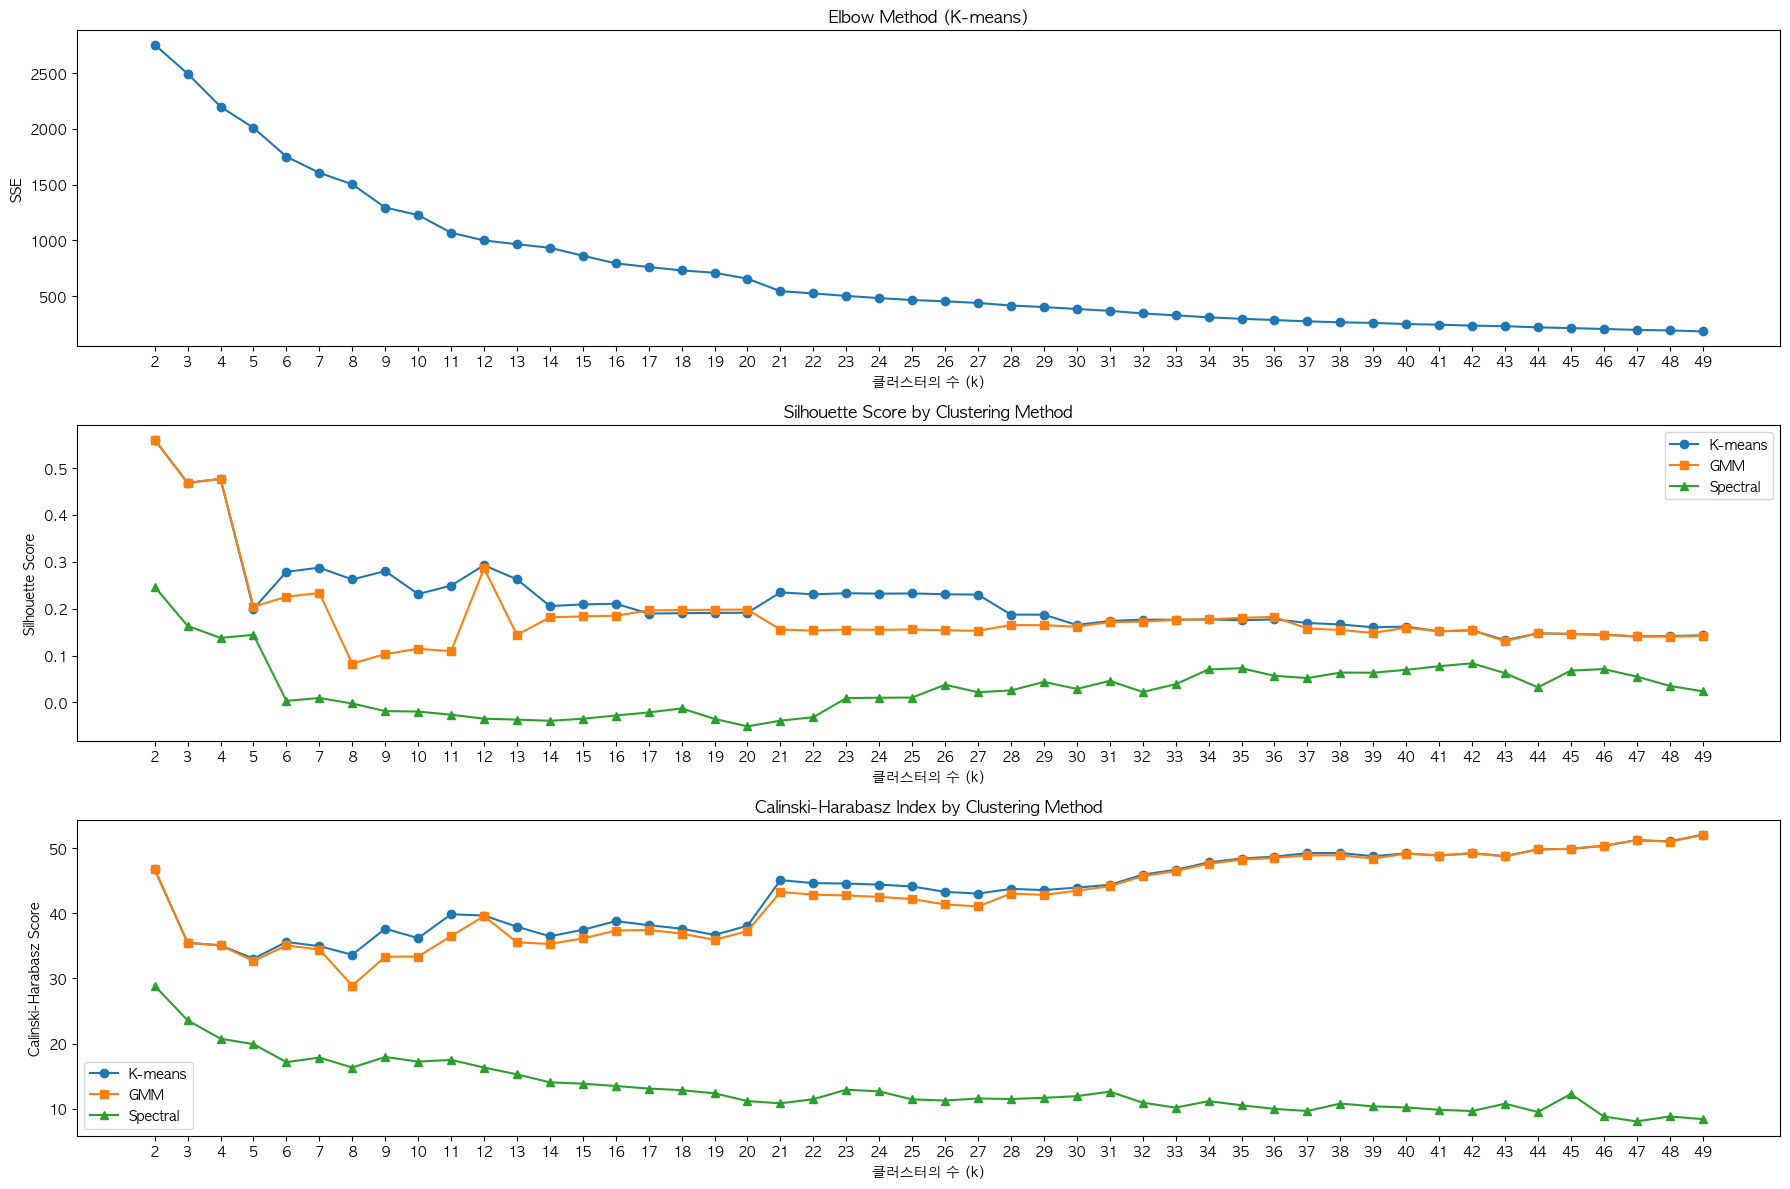

In [43]:
# 후보 K 값 범위 설정
k_values = range(2, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가 (2020-2022)
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels_2020_2022 = kmeans.fit_predict(X_scaled_df_2020_2022)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022))
    ch_scores.append(calinski_harabasz_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2020_2022 = gmm.fit_predict(X_scaled_df_2020_2022)
    gmm_silhouette_scores.append(silhouette_score(X_scaled_df_2020_2022, gmm_labels_2020_2022))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled_df_2020_2022, gmm_labels_2020_2022))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels_2020_2022 = spectral.fit_predict(X_scaled_df_2020_2022)
    spectral_silhouette_scores.append(silhouette_score(X_scaled_df_2020_2022, spectral_labels_2020_2022))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled_df_2020_2022, spectral_labels_2020_2022))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [44]:
# Window 2020-2022
# 3가지 평가 지표를 보고 k값을 결정함

# K-means clustering
# K-means는 k=12에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans_labels_2020_2022, kmeans_score_2020_2022 = evaluate_clustering(kmeans, X_scaled_df_2020_2022)

# GMM
# GMM은 k=4에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels_2020_2022, gmm_score_2020_2022 = evaluate_clustering(gmm, X_scaled_df_2020_2022, labels=gmm.fit_predict(X_scaled_df_2020_2022))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=42, random_state=42, affinity='nearest_neighbors')
spectral_labels_2020_2022, spectral_score_2020_2022 = evaluate_clustering(spectral, X_scaled_df_2020_2022)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi_2020_2022 = davies_bouldin_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022)
gmm_dbi_2020_2022 = davies_bouldin_score(X_scaled_df_2020_2022, gmm_labels_2020_2022)
spectral_dbi_2020_2022 = davies_bouldin_score(X_scaled_df_2020_2022, spectral_labels_2020_2022)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi_2020_2022:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi_2020_2022:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi_2020_2022:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.9446
GMM Davies-Bouldin Index: 1.2032
Spectral Davies-Bouldin Index: 1.2581


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [45]:
# K-means가 0.9446로 값이 가장 낮게 나왔다.
df_2020_2022['Cluster'] = kmeans_labels_2020_2022

### Random Forest 학습 - XAI 해석용

In [46]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled_df_2020_2022, kmeans_labels_2020_2022)

RandomForestClassifier(random_state=42)

### SHAP 해석

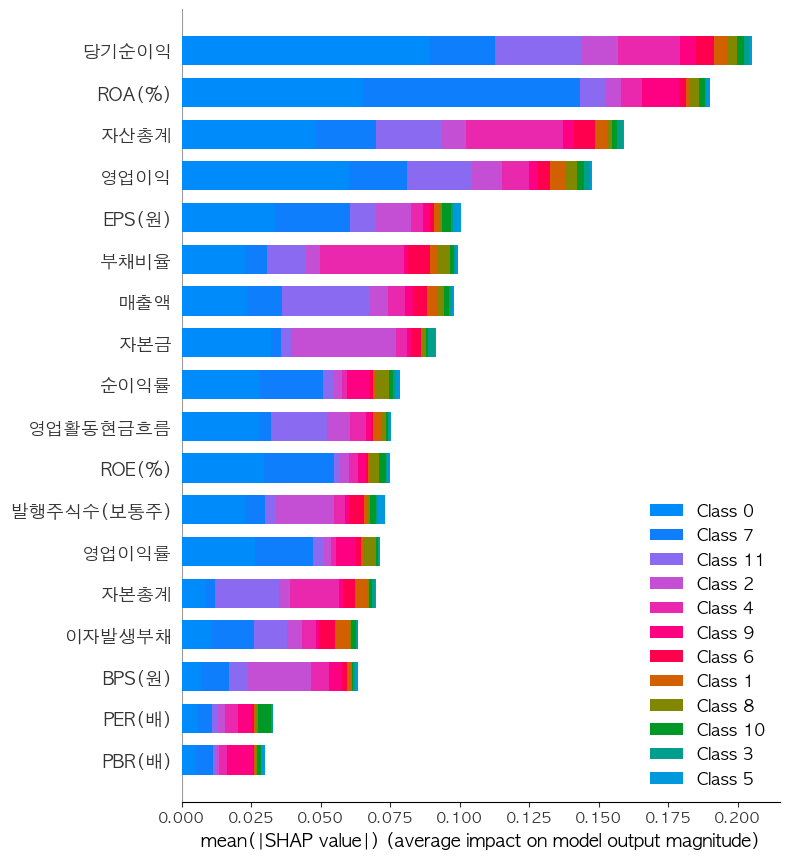

In [47]:
# SHAP 분석
explainer_2020_2022 = shap.TreeExplainer(clf)
shap_values_2020_2022 = explainer_2020_2022.shap_values(X_scaled_df_2020_2022)

# feature importance를 시각화함
shap.summary_plot(shap_values_2020_2022, X_raw_2020_2022, plot_type="bar")

In [48]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2020_2022 = {}
for cluster_id in range(kmeans.n_clusters):
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(kmeans_labels_2020_2022 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2020_2022[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_raw_2020_2022.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2020_2022[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_raw_2020_2022.columns)

# 각 클래스별 중요도 추가
for cluster_id in range(kmeans.n_clusters):
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(cluster_shap_means_2020_2022[cluster_id]) != len(X_raw_2020_2022.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(cluster_shap_means_2020_2022[cluster_id])})가 특성 수({len(X_raw_2020_2022.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = cluster_shap_means_2020_2022[cluster_id]

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
print(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in range(kmeans.n_clusters):
    if f'Class {cluster_id}' not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    class_importance = feature_importance_df[f'Class {cluster_id}'].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(class_importance.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):
             Class 0   Class 1   Class 2   Class 3   Class 4   Class 5  \
매출액         0.021910  0.049497  0.011310  0.030131  0.018351  0.010934   
영업이익        0.052141  0.117733  0.048876  0.026172  0.085762  0.040295   
당기순이익       0.082709  0.152305  0.071241  0.008306  0.129873  0.007108   
자산총계        0.041506  0.096958  0.045780  0.073315  0.130859  0.015448   
자본총계        0.009064  0.027664  0.002926  0.020659  0.004979  0.003098   
자본금         0.021655  0.036576  0.179927  0.171192  0.021600  0.005379   
영업활동현금흐름    0.024854  0.062339  0.041335  0.001978  0.024802  0.015803   
이자발생부채      0.011117  0.014206  0.011459  0.013973  0.014613  0.001395   
영업이익률       0.022014  0.007935  0.015060  0.029236  0.011869  0.008913   
순이익률        0.026256  0.010559  0.012344  0.023486  0.013131  0.013411   
ROE(%)      0.027560  0.012476  0.020175  0.038667  0.016488  0.023415   
ROA(%)      0.051943  0.015011  0.020145  0.006474  0.023690  0.041566   
부채비율       

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### 각 cluster에 어떤 종목이 포함되어 있는지 확인

In [49]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in range(kmeans.n_clusters):
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company_2020_2022[kmeans_labels_2020_2022 == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
BGF리테일, CJ대한통운, DL, DL이앤씨, GS건설, GS리테일, HD한국조선해양, HD현대미포, HD현대인프라코어, HD현대일렉트릭, HL만도, KCC, KG모빌리티, LG에너지솔루션, LIG넥스원, LS, LS ELECTRIC, SKC, SK네트웍스, SK스퀘어, SK아이이테크놀로지, SK케미칼, TCC스틸, TKG휴켐스, 강원랜드, 넷마블, 녹십자, 녹십자홀딩스, 농심, 대상, 대웅, 대웅제약, 대한유화, 대한전선, 더블유게임즈, 동서, 동원시스템즈, 두산, 두산밥캣, 두산퓨얼셀, 롯데쇼핑, 롯데웰푸드, 롯데지주, 롯데칠성, 롯데케미칼, 미스토홀딩스, 삼성E&A, 삼성에스디에스, 삼성카드, 삼아알미늄, 삼양식품, 세방전지, 세아베스틸지주, 신세계, 씨에스윈드, 아모레퍼시픽, 아모레퍼시픽홀딩스, 에스엘, 에스원, 엘앤에프, 오리온홀딩스, 유한양행, 율촌화학, 일진하이솔루스, 제일기획, 종근당, 카카오, 카카오페이, 코스맥스, 코스모신소재, 코스모화학, 코오롱인더, 포스코DX, 포스코인터내셔널, 포스코퓨처엠, 풍산, 하이브, 하이트진로, 한국앤컴퍼니, 한국콜마, 한국타이어앤테크놀로지, 한국항공우주, 한미사이언스, 한미약품, 한샘, 한세실업, 한온시스템, 한일시멘트, 한전KPS, 한전기술, 한화솔루션, 한화시스템, 한화에어로스페이스, 현대건설, 현대글로비스, 현대로템, 현대백화점, 현대엘리베이터, 현대위아, 호텔신라, 효성중공업, 후성
[클러스터 1에 속한 종목들]:
POSCO홀딩스, SK, 현대차
[클러스터 2에 속한 종목들]:
LG디스플레이, LG유플러스, NH투자증권, 금호타이어, 대우건설, 대한항공, 두산에너빌리티, 미래에셋증권, 삼성중공업, 카카오뱅크, 팬오션, 한화생명
[클러스터 3에 속한 종목들]:
한국전력
[클러스터 4에 속한 종목들]:
BNK금융지주, DB손해보험, JB금융지주, iM금융지주, 메리츠금융지주, 삼성증권, 삼성화재, 키움증권, 한국가스공사, 한국금융지주, 현대해상
[클러스터 5에 속한 종목들]

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

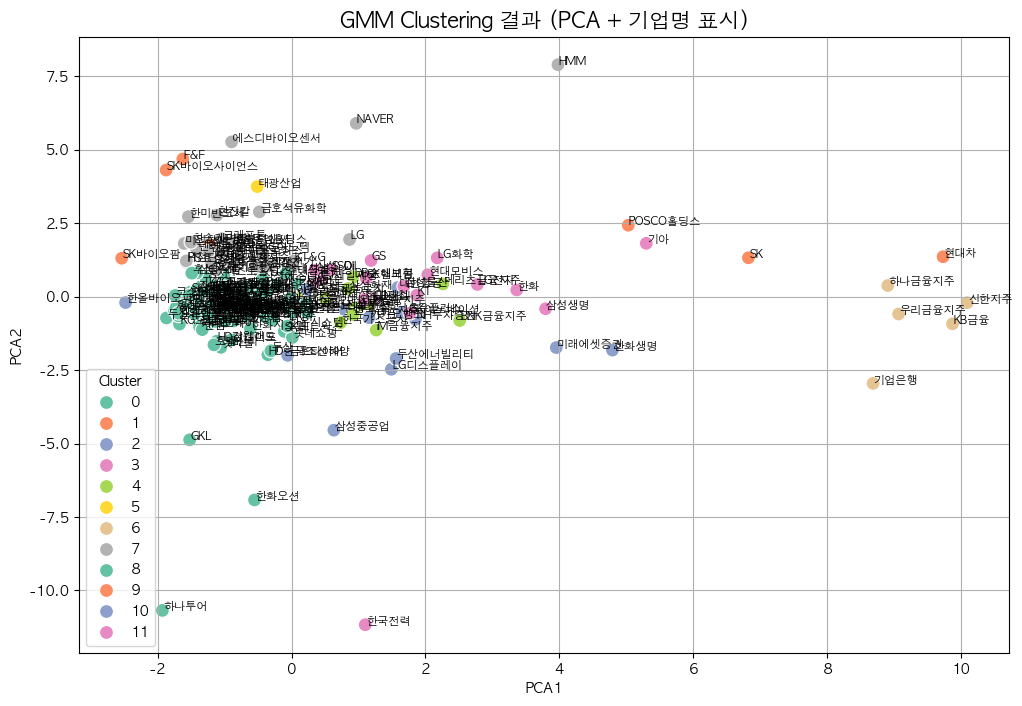

In [50]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_2020_2022)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company_2020_2022.values,
    'Cluster': kmeans_labels_2020_2022,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2021-2023)

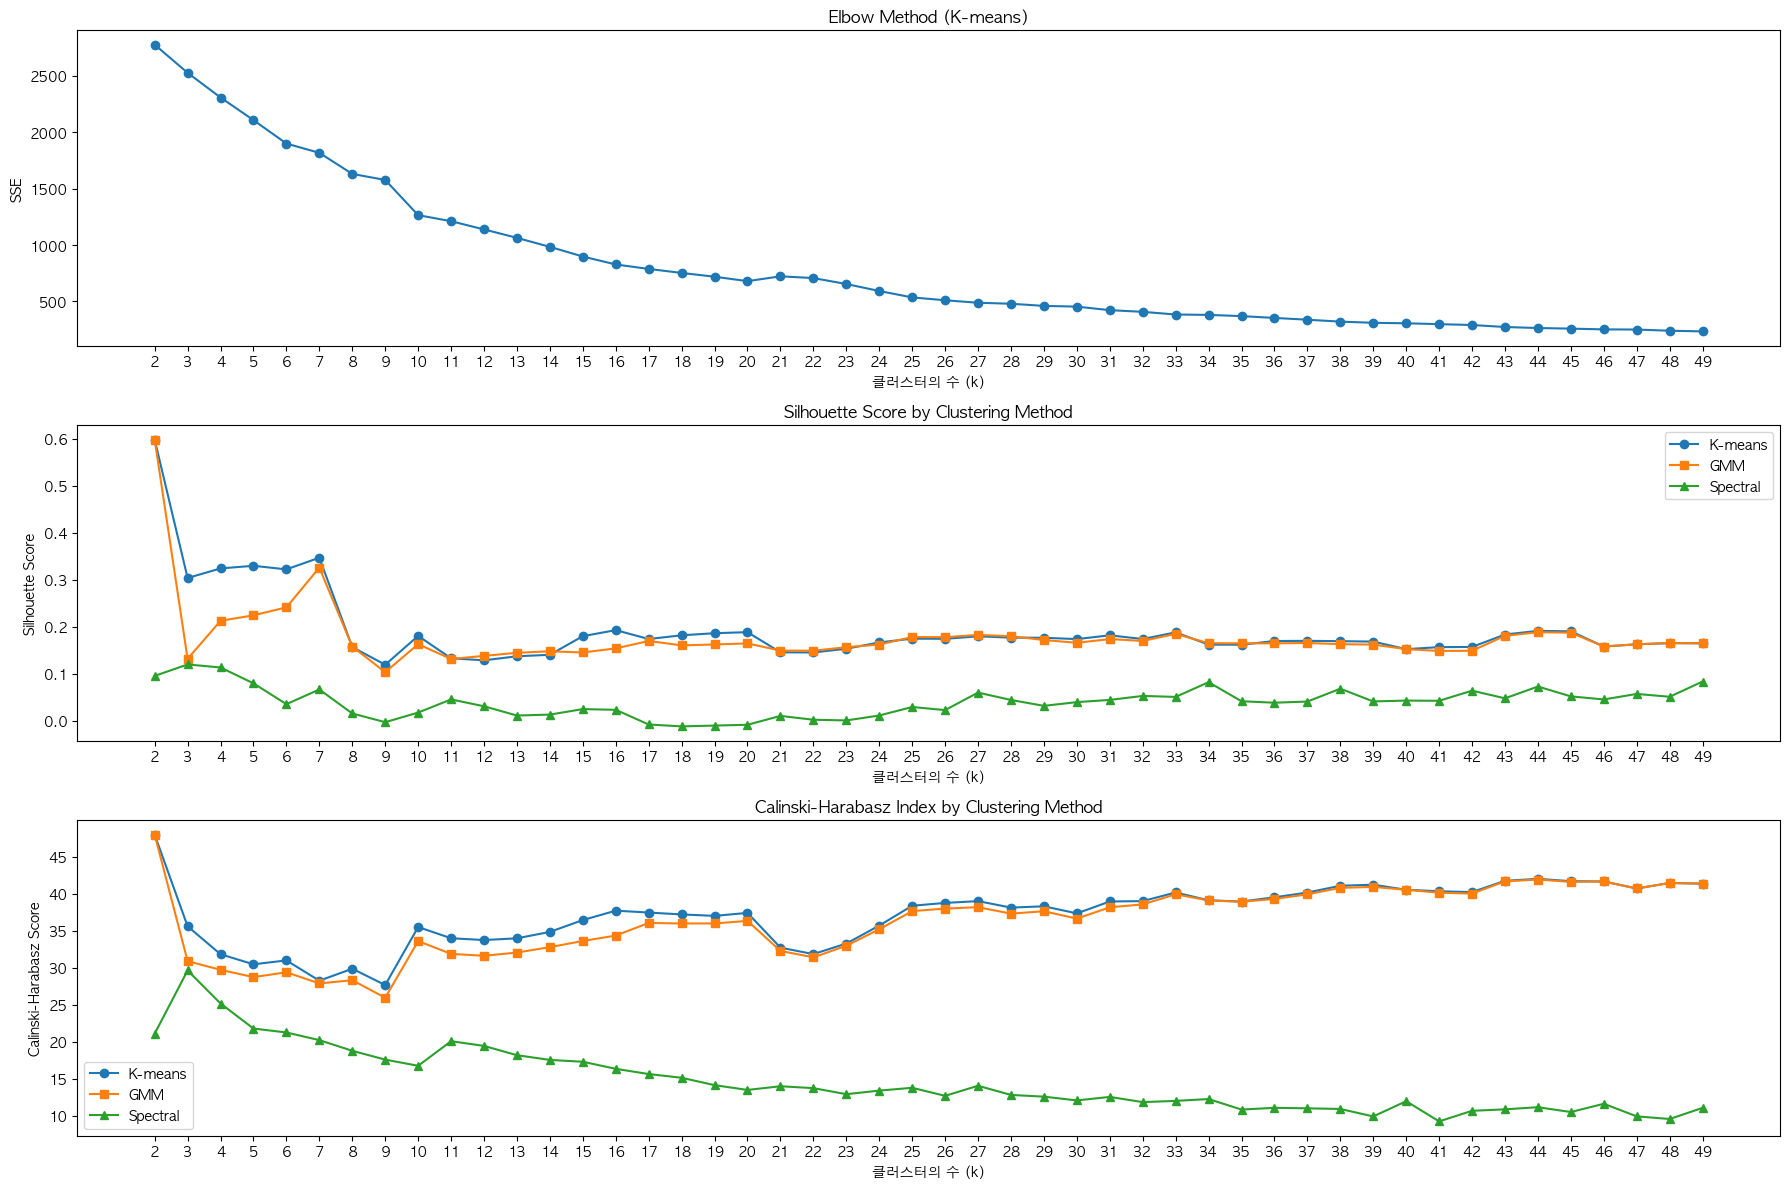

In [38]:
# 후보 K 값 범위 설정
k_values = range(2, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가 (2020-2022)
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels_2021_2023 = kmeans.fit_predict(X_scaled_df_2021_2023)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023))
    ch_scores.append(calinski_harabasz_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2021_2023 = gmm.fit_predict(X_scaled_df_2021_2023)
    gmm_silhouette_scores.append(silhouette_score(X_scaled_df_2021_2023, gmm_labels_2021_2023))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled_df_2021_2023, gmm_labels_2021_2023))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels_2021_2023 = spectral.fit_predict(X_scaled_df_2021_2023)
    spectral_silhouette_scores.append(silhouette_score(X_scaled_df_2021_2023, spectral_labels_2021_2023))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled_df_2021_2023, spectral_labels_2021_2023))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [42]:
# Window 2021-2023
# 3가지 평가 지표를 보고 k값을 결정함

# K-means clustering
# K-means는 k=10에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels_2021_2023, kmeans_score_2021_2023 = evaluate_clustering(kmeans, X_scaled_df_2021_2023)

# GMM
# GMM은 k=7에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=7, random_state=42)
gmm_labels_2021_2023, gmm_score_2021_2023 = evaluate_clustering(gmm, X_scaled_df_2021_2023, labels=gmm.fit_predict(X_scaled_df_2021_2023))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors')
spectral_labels_2021_2023, spectral_score_2021_2023 = evaluate_clustering(spectral, X_scaled_df_2021_2023)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi_2021_2023 = davies_bouldin_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023)
gmm_dbi_2021_2023 = davies_bouldin_score(X_scaled_df_2021_2023, gmm_labels_2021_2023)
spectral_dbi_2021_2023 = davies_bouldin_score(X_scaled_df_2021_2023, spectral_labels_2021_2023)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi_2021_2023:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi_2021_2023:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi_2021_2023:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.9706
GMM Davies-Bouldin Index: 1.0609
Spectral Davies-Bouldin Index: 1.7180


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [51]:
# K-means가 0.9706로 값이 가장 낮게 나왔다.
df_2021_2023['Cluster'] = kmeans_labels_2021_2023

### Random Forest 학습 - XAI 해석용

In [52]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled_df_2021_2023, kmeans_labels_2021_2023)

RandomForestClassifier(random_state=42)

### SHAP 해석

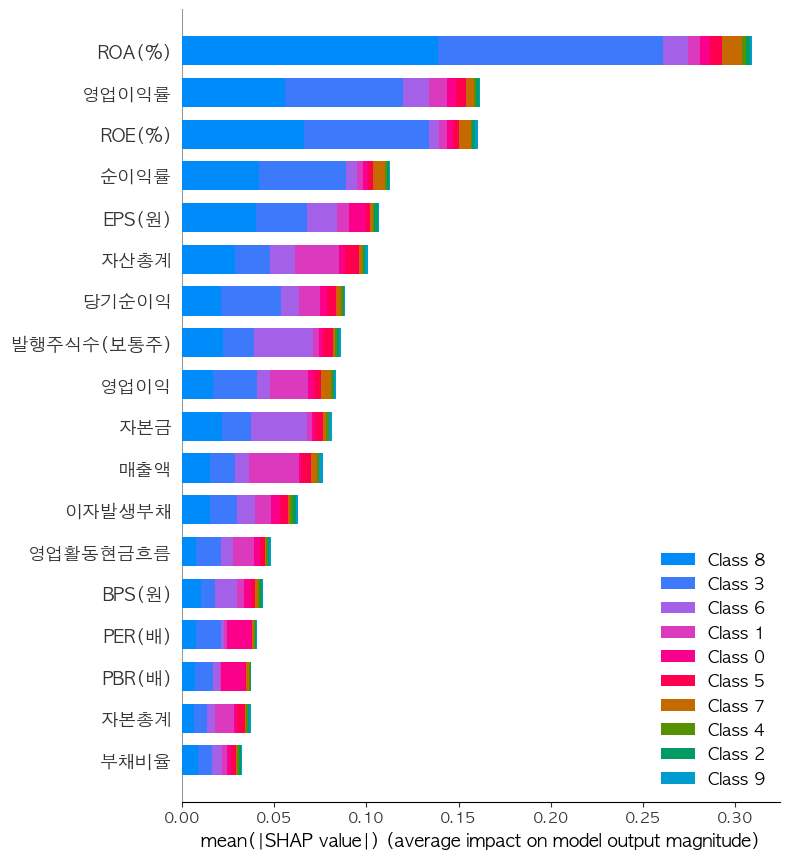

In [53]:
# SHAP 분석
explainer_2021_2023 = shap.TreeExplainer(clf)
shap_values_2021_2023 = explainer_2021_2023.shap_values(X_scaled_df_2021_2023)

# feature importance를 시각화함
shap.summary_plot(shap_values_2021_2023, X_raw_2021_2023, plot_type="bar")

In [54]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2021_2023 = {}
for cluster_id in range(kmeans.n_clusters):
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(kmeans_labels_2021_2023 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2021_2023[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_raw_2021_2023.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2021_2023[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_raw_2021_2023.columns)

# 각 클래스별 중요도 추가
for cluster_id in range(kmeans.n_clusters):
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(cluster_shap_means_2021_2023[cluster_id]) != len(X_raw_2021_2023.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(cluster_shap_means_2021_2023[cluster_id])})가 특성 수({len(X_raw_2021_2023.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = cluster_shap_means_2021_2023[cluster_id]

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
print(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in range(kmeans.n_clusters):
    if f'Class {cluster_id}' not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    class_importance = feature_importance_df[f'Class {cluster_id}'].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(class_importance.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):
             Class 0   Class 1   Class 2   Class 3   Class 4   Class 5  \
매출액         0.011379  0.002724  0.002729  0.001181  0.000268  0.001931   
영업이익        0.026058  0.003160  0.003590  0.002995  0.002632  0.002294   
당기순이익       0.037169  0.002637  0.008136  0.003039  0.003028  0.002462   
자산총계        0.028569  0.003854  0.001252  0.001894  0.003464  0.003093   
자본총계        0.013628  0.001163  0.000276  0.001562  0.001270  0.001044   
자본금         0.013383  0.000255  0.000531  0.001366  0.002183  0.001214   
영업활동현금흐름    0.023804  0.002015  0.000511  0.003079  0.009044  0.001430   
이자발생부채      0.032058  0.003021  0.012659  0.005828  0.003476  0.001963   
영업이익률       0.033871  0.001873  0.003982  0.003498  0.002528  0.002139   
순이익률        0.022902  0.001004  0.001023  0.002127  0.001103  0.000907   
ROE(%)      0.043232  0.001116  0.001283  0.002376  0.002291  0.001443   
ROA(%)      0.038118  0.000598  0.003691  0.007436  0.004301  0.000412   
부채비율       

/var/folders/vw/vspwd_yn6b94yd37dg899j380000gn/T/ipykernel_71715/882892368.py:11: RuntimeWarning: Mean of empty slice.
  cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

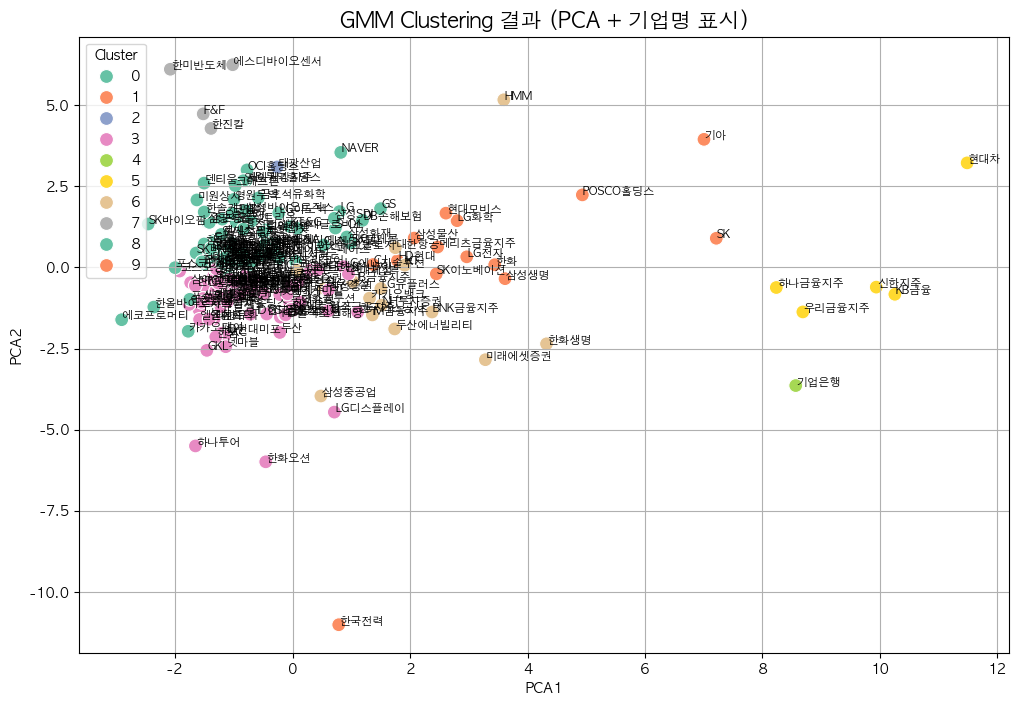

In [55]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_2021_2023)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company_2021_2023.values,
    'Cluster': kmeans_labels_2021_2023,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2022-2024)

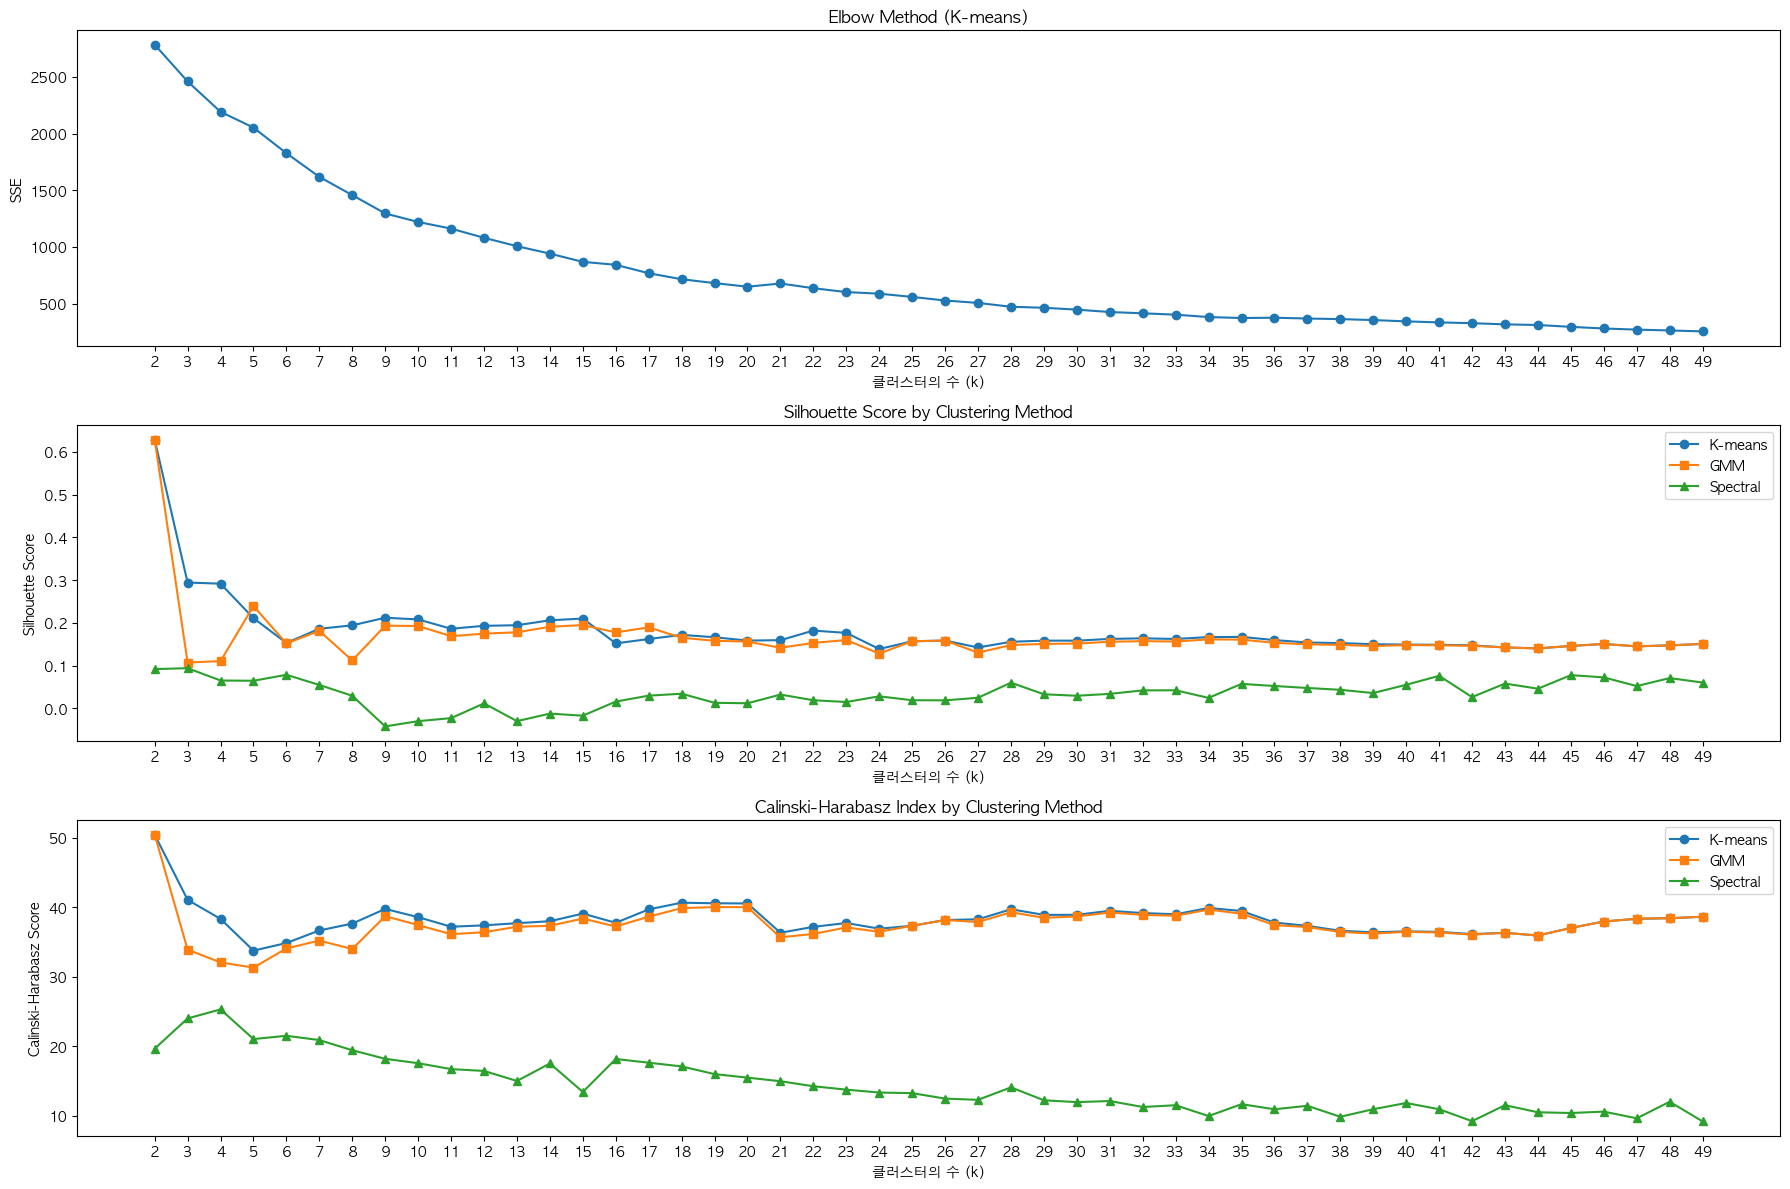

In [56]:
# 후보 K 값 범위 설정
k_values = range(2, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가 (2020-2022)
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels_2022_2024 = kmeans.fit_predict(X_scaled_df_2022_2024)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024))
    ch_scores.append(calinski_harabasz_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2022_2024 = gmm.fit_predict(X_scaled_df_2022_2024)
    gmm_silhouette_scores.append(silhouette_score(X_scaled_df_2022_2024, gmm_labels_2022_2024))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled_df_2022_2024, gmm_labels_2022_2024))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels_2022_2024 = spectral.fit_predict(X_scaled_df_2022_2024)
    spectral_silhouette_scores.append(silhouette_score(X_scaled_df_2022_2024, spectral_labels_2022_2024))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled_df_2022_2024, spectral_labels_2022_2024))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [69]:
# Window 2021-2023
# 3가지 평가 지표를 보고 k값을 결정함

# K-means clustering
# K-means는 k=13에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans_labels_2022_2024, kmeans_score_2022_2024 = evaluate_clustering(kmeans, X_scaled_df_2022_2024)

# GMM
# GMM은 k=9에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=9, random_state=42)
gmm_labels_2022_2024, gmm_score_2022_2024 = evaluate_clustering(gmm, X_scaled_df_2022_2024, labels=gmm.fit_predict(X_scaled_df_2022_2024))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=4, random_state=42, affinity='nearest_neighbors')
spectral_labels_2022_2024, spectral_score_2022_2024 = evaluate_clustering(spectral, X_scaled_df_2022_2024)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi_2022_2024 = davies_bouldin_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024)
gmm_dbi_2022_2024 = davies_bouldin_score(X_scaled_df_2022_2024, gmm_labels_2022_2024)
spectral_dbi_2022_2024 = davies_bouldin_score(X_scaled_df_2022_2024, spectral_labels_2022_2024)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi_2022_2024:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi_2022_2024:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi_2022_2024:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.8026
GMM Davies-Bouldin Index: 1.1350
Spectral Davies-Bouldin Index: 1.7180


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [70]:
# K-means가 0.9706로 값이 가장 낮게 나왔다.
df_2022_2024['Cluster'] = kmeans_labels_2022_2024

### Random Forest 학습 - XAI 해석용

In [71]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled_df_2022_2024, kmeans_labels_2022_2024)

RandomForestClassifier(random_state=42)

### SHAP 해석

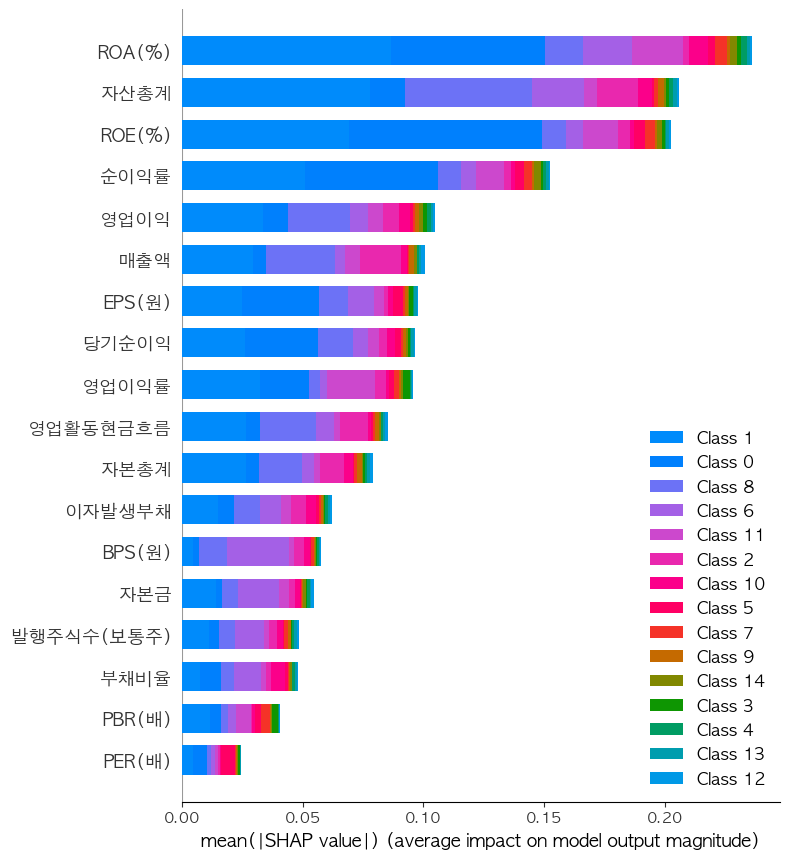

In [72]:
# SHAP 분석
explainer_2022_2024 = shap.TreeExplainer(clf)
shap_values_2022_2024 = explainer_2022_2024.shap_values(X_scaled_df_2022_2024)

# feature importance를 시각화함
shap.summary_plot(shap_values_2022_2024, X_raw_2022_2024, plot_type="bar")

In [73]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2022_2024 = {}
for cluster_id in range(kmeans.n_clusters):
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(kmeans_labels_2022_2024 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2022_2024[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_raw_2022_2024.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2022_2024[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_raw_2022_2024.columns)

# 각 클래스별 중요도 추가
for cluster_id in range(kmeans.n_clusters):
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(cluster_shap_means_2022_2024[cluster_id]) != len(X_raw_2022_2024.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(cluster_shap_means_2022_2024[cluster_id])})가 특성 수({len(X_raw_2022_2024.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = cluster_shap_means_2022_2024[cluster_id]

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
print(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in range(kmeans.n_clusters):
    if f'Class {cluster_id}' not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    class_importance = feature_importance_df[f'Class {cluster_id}'].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(class_importance.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):
             Class 0   Class 1   Class 2   Class 3   Class 4   Class 5  \
매출액         0.009050  0.001594  0.031884  0.003005  0.000398  0.001077   
영업이익        0.018754  0.003860  0.023672  0.007559  0.024039  0.005925   
당기순이익       0.060147  0.020017  0.034980  0.015266  0.024751  0.032871   
자산총계        0.023493  0.005172  0.055521  0.007814  0.031098  0.017198   
자본총계        0.010547  0.001332  0.027090  0.001464  0.011059  0.003570   
자본금         0.005670  0.001160  0.001764  0.003338  0.004107  0.003123   
영업활동현금흐름    0.009201  0.001192  0.029713  0.006347  0.001497  0.012540   
이자발생부채      0.014439  0.003348  0.017947  0.002809  0.013276  0.012100   
영업이익률       0.044800  0.015304  0.012889  0.048534  0.014959  0.013198   
순이익률        0.139291  0.034576  0.039781  0.039802  0.021372  0.094072   
ROE(%)      0.183709  0.058338  0.052643  0.062016  0.033323  0.068281   
ROA(%)      0.122245  0.054228  0.035957  0.064958  0.037168  0.074812   
부채비율       

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

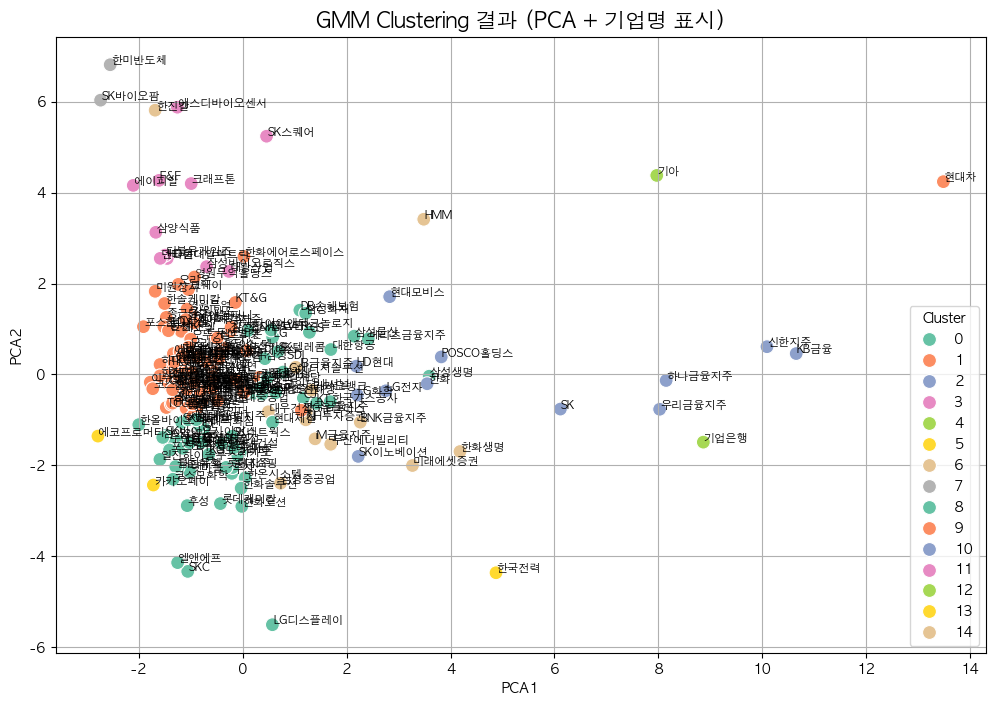

In [74]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_2022_2024)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company_2022_2024.values,
    'Cluster': kmeans_labels_2022_2024,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()